In [19]:
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from scipy.integrate import quad, simpson
from scipy.interpolate import interp1d

import astropy.constants as c
import astropy.units as u
from dustpy import Simulation, plot
import matplotlib as mpl
import numpy as np
from simframe.frame import Field

# mpl.use('macosx')
mpl.use('module://matplotlib_inline.backend_inline')

/var/folders/pk/jhhfnyms709gx_l1zpjl8d0w0000gp/T/ipykernel_40310/2479650664.py:15: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  mpl.use('module://matplotlib_inline.backend_inline')


In [3]:
m_disk = 0.11 * c.M_sun.cgs.value
m_disk

2.187250857767856e+32

### Simulation gas profile

Use the CO brightness profile as the gas profile for the simulation. First load from file the observed profile, then interpolate it.

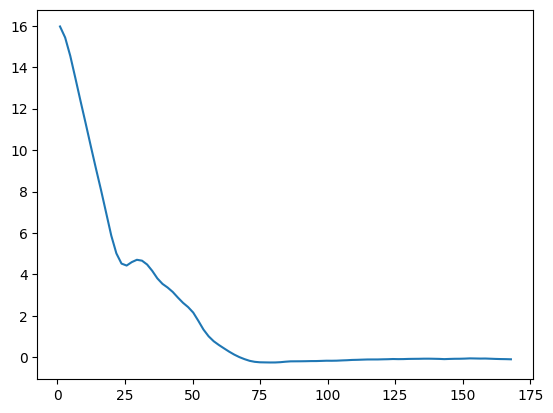

In [4]:
fname_profile = Path('./profile_C18O.pickle')

with open(fname_profile, 'rb') as f:
    profile_C18O = pickle.load(f)
    
f, ax = plt.subplots()
ax.plot(profile_C18O['x'] * u.cm.to(u.au), profile_C18O['y'])


def interp_profile_norm(radius: float, profile_dict: dict, total_disk_mass: float) -> float:
    """
    Interpolate a profile to use as gas surface density, normalized to a given total disk mass.
    
    Parameters
    ----------
    radius: float
        Radius where to evaluate the gas surface density.
    profile_dict: dict
        Dictionary containing the profile to use as surface density distribution. The keys must be named 'x' and 'y'.
    total_disk_mass: float
        Total disk mass.
        
    Returns
    -------
    float
        Normalized gas surface density at radius 'radius'.
    """
    
    normalization_constant = total_disk_mass / simpson(2 * np.pi * profile_dict['x'] * profile_dict['y'], profile_dict['x'])
    interp_profile = interp1d(profile_dict['x'], profile_dict['y'], fill_value='extrapolate', kind='quadratic')
    
    return normalization_constant * interp_profile(radius)


Create the radial grid through the Simulation class to compute sigma_mas. This breaks the class methods, so plug the 
sigma_gas into a new class instance.

In [5]:
sim = Simulation()
sim.ini.grid.rmax = profile_C18O['x'].max()
sim.ini.gas.Mdisk = m_disk
sim._makeradialgrid()


In [6]:
SigmaGas = np.array(interp_profile_norm(sim.grid.r, profile_C18O, sim.ini.gas.Mdisk))
sigma_gas = Field(sim, SigmaGas, description="Surface density [g/cm²]")


/var/folders/pk/jhhfnyms709gx_l1zpjl8d0w0000gp/T/ipykernel_40310/345107780.py:29: DeprecationWarning: You are passing x=[1.41887260e+13 4.25661779e+13 7.09436298e+13 9.93210817e+13
 1.27698534e+14 1.56075985e+14 1.84453437e+14 2.12830889e+14
 2.41208341e+14 2.69585793e+14 2.97963245e+14 3.26340697e+14
 3.54718149e+14 3.83095601e+14 4.11473053e+14 4.39850504e+14
 4.68227956e+14 4.96605408e+14 5.24982860e+14 5.53360312e+14
 5.81737764e+14 6.10115216e+14 6.38492668e+14 6.66870120e+14
 6.95247572e+14 7.23625023e+14 7.52002475e+14 7.80379927e+14
 8.08757379e+14 8.37134831e+14 8.65512283e+14 8.93889735e+14
 9.22267187e+14 9.50644639e+14 9.79022091e+14 1.00739954e+15
 1.03577699e+15 1.06415445e+15 1.09253190e+15 1.12090935e+15
 1.14928680e+15 1.17766425e+15 1.20604171e+15 1.23441916e+15
 1.26279661e+15 1.29117406e+15 1.31955151e+15 1.34792897e+15
 1.37630642e+15 1.40468387e+15 1.43306132e+15 1.46143877e+15
 1.48981622e+15 1.51819368e+15 1.54657113e+15 1.57494858e+15
 1.60332603e+15 1.63170348

In [7]:
sim = Simulation()
sim.ini.grid.rmax = profile_C18O['x'].max()
sim.ini.gas.Mdisk = m_disk
sim.gas.Sigma = sigma_gas
sim.initialize()
del(sim.integrator.instructions[1])


In [8]:
model_dir = Path("data_C18O")
sim.writer.datadir = str(model_dir)
if not model_dir.exists():
    sim.run()


### <span style="color:red">Testing area</span>

In [9]:
sim.ini.dust

namespace(aIniMax=0.0001,
          allowDriftingParticles=False,
          erosionMassRatio=10.0,
          d2gRatio=0.01,
          distExp=-3.5,
          excavatedMass=1.0,
          fragmentDistribution=-1.8333333333333333,
          rhoMonomer=1.67,
          vfrag=100.0)

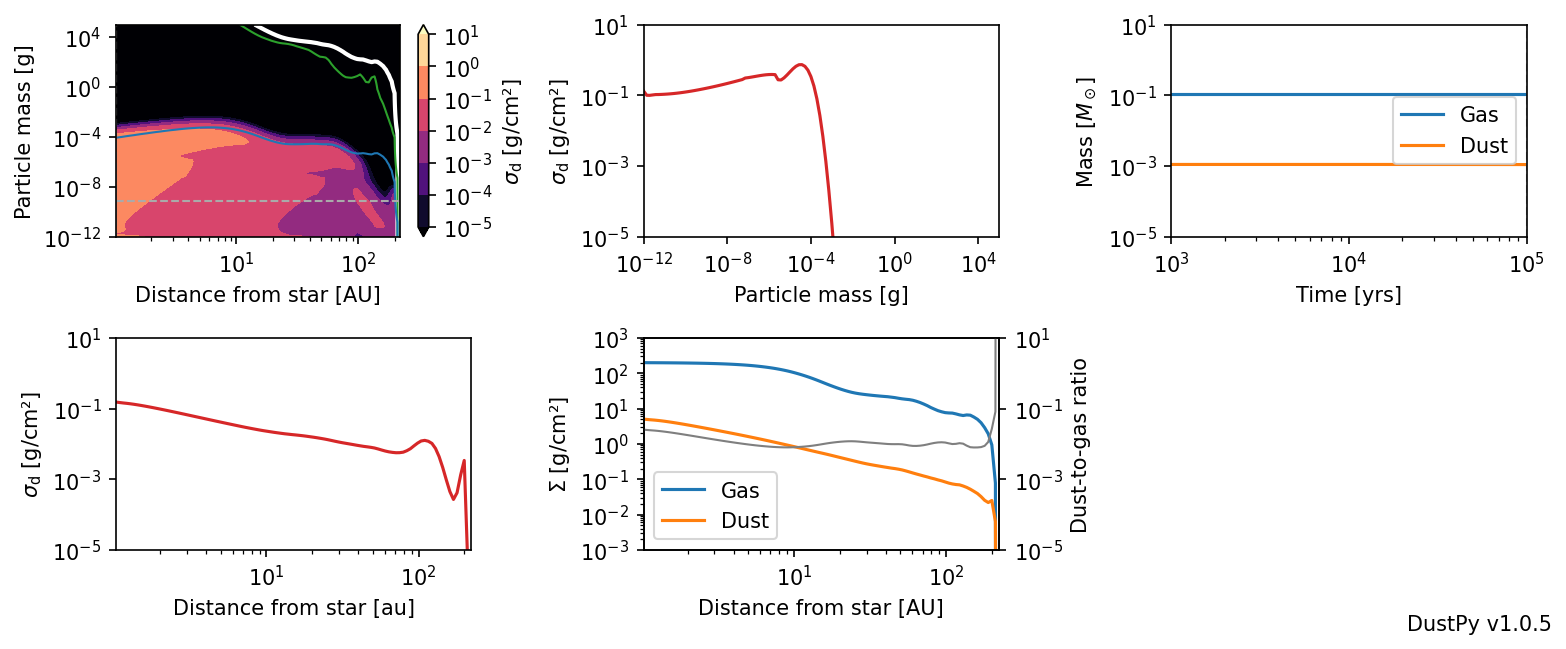

In [25]:
# plot.panel('data_mod_profile', im=10, it=20)
plot.panel('data_CO_profile', im=20, it=100)

In [18]:
plot.ipanel('data_CO_profile')

In [12]:
sim_test = Simulation()
sim_test.initialize()
# sim_test.run()
sim_test.ini.gas

namespace(alpha=0.001,
          gamma=1.4,
          Mdisk=9.942049353490256e+31,
          mu=3.847030424486999e-24,
          SigmaExp=-1.0,
          SigmaRc=897587224200000.0)

/var/folders/pk/jhhfnyms709gx_l1zpjl8d0w0000gp/T/ipykernel_40310/42728241.py:7: DeprecationWarning: You are passing x=Field (Radial grid cell centers [cm]), constant as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  simpson(sim_test.gas.Sigma * 2 * np.pi * sim_test.grid.r, sim_test.grid.r), simpson(sim.gas.Sigma * 2 * np.pi *


(9.771848740796742e+31, 2.771172354539124e+32)

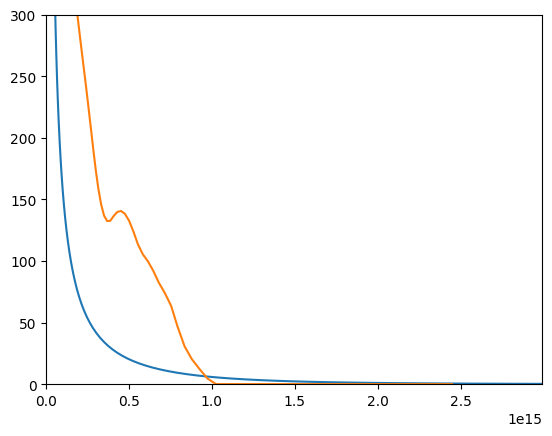

In [13]:
plt.plot(sim_test.grid.r, sim_test.gas.Sigma)
plt.plot(sim.grid.r, sim.gas.Sigma)
plt.xlim(0, (200 * u.au).to_value(u.cm))
plt.ylim(0, 300)

from scipy.integrate import simpson
simpson(sim_test.gas.Sigma * 2 * np.pi * sim_test.grid.r, sim_test.grid.r), simpson(sim.gas.Sigma * 2 * np.pi * 
                                                                                   sim.grid.r, sim.grid.r)

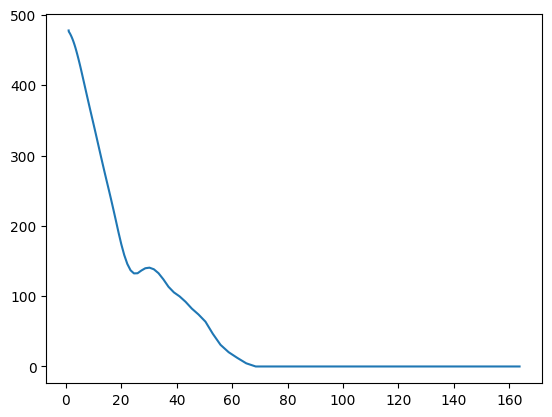

In [14]:
plt.plot(sim.grid.r * u.cm.to(u.au), sim.gas.Sigma)
# plt.ylim((10, 40))
# plt.ylim((10, 40))
# plt.xlim(20, 120)